In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fpdf import FPDF
from PIL import Image

In [2]:
#Função CCI - TRI 3PL

In [3]:
def tri_3pl_enem(theta, a, b, c):
    return c + (1 - c) * (1 / (1 + np.exp(-1.7 * a * (theta - b))))

In [4]:
# Plotando a curva do modelo logístico de três parâmetros (TRI)

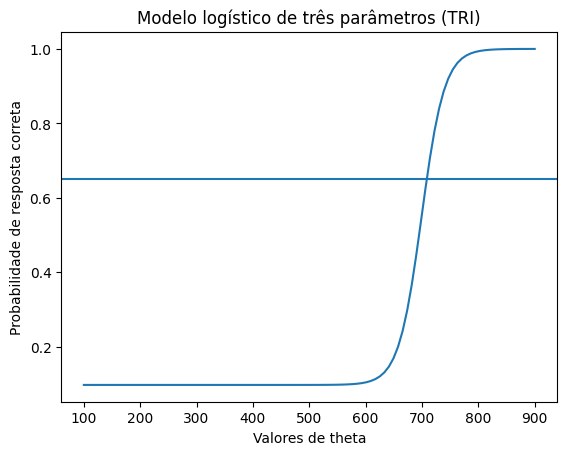

In [5]:
def plot_graphic(a, b, c):
    theta_vals = np.linspace(-4, 4, num=100)
    y_vals = [tri_3pl_enem(x, a, b, c) for x in theta_vals]
    plt.plot(((theta_vals*100)+500), y_vals)
    plt.xlabel("Valores de theta")
    plt.ylabel("Probabilidade de resposta correta")
    plt.title("Modelo logístico de três parâmetros (TRI)")
    plt.axhline(y=0.65, xmin=-4)
    plt.show()

plot_graphic(2.898, 1.992, 0.097)

In [6]:
# Encontrando o valor de theta que resulta em targ (padrão 0.65)

In [7]:
def find_theta(a, b, c, targ):
    left = -100
    right = 100
    tol = 1e-5
    target = targ
    while (right - left) / 2 > tol:
        theta = (left + right) / 2
        value = tri_3pl_enem(theta, a, b, c)
        if value > target:
            right = theta
        else:
            left = theta
    return theta * 100 + 500

In [8]:
#Colocando as proficiências na tabela de itens dos microdados.

In [9]:
def thetaToCsv(provas, dfItens):
    dfItens = dfItens[dfItens.CO_PROVA.isin(provas)]
    dfItens["theta_065"] = 0
    dfItens["theta_080"] = 0
    dfItens["theta_099"] = 0
    for i in dfItens.index:    
        dfItens.loc[i, "theta_065"] = find_theta(
            dfItens.loc[i, "NU_PARAM_A"],
            dfItens.loc[i, "NU_PARAM_B"],
            dfItens.loc[i, "NU_PARAM_C"],
            0.65,
        )
        dfItens.loc[i, "theta_080"] = find_theta(
            dfItens.loc[i, "NU_PARAM_A"],
            dfItens.loc[i, "NU_PARAM_B"],
            dfItens.loc[i, "NU_PARAM_C"],
            0.80,
        )
        dfItens.loc[i, "theta_099"] = find_theta(
            dfItens.loc[i, "NU_PARAM_A"],
            dfItens.loc[i, "NU_PARAM_B"],
            dfItens.loc[i, "NU_PARAM_C"],
            0.99,
        )
    return dfItens

In [10]:
#Definindo Classe do PDF de Saída

In [11]:
class PDF(FPDF):
    def header(self):
        self.image('3.png', x=0, y=0, w=self.w, h=self.h, type='png')
    # Page footer
    def footer(self):
        # Position at 1.5 cm from bottom
        self.set_y(-15)
        # Arial italic 8
        self.set_font('Arial', 'BI', 8)
        # Page number
        self.cell(0, 12, 'Página ' + str(self.page_no()) + '/{nb}' + ' por @niedson.studiesmed', 0, 0, 'C')

In [12]:
#Função que gera a lista de Treino de TRI

In [13]:
def questionBalance_65(name, nota_mat, dfResult):
    nota_matMaior = nota_mat * 1.07
    nota_matMenor = nota_mat / 1.07
    dfResult = dfResult[dfResult['IN_ITEM_ABAN'] == 0]
    dfResult = dfResult[dfResult['TP_LINGUA'] != 0]
    dfResult = dfResult[dfResult['TP_LINGUA'] != 1]
    cols_to_drop = ['TP_LINGUA', 'TX_MOTIVO_ABAN', 'IN_ITEM_ABAN', 'IN_ITEM_ADAPTADO', 'NU_PARAM_A', 'NU_PARAM_B', 'NU_PARAM_C']
    dfResult.drop(cols_to_drop, axis=1, inplace=True)
    # Para a área de Matemática (MT)
    dfResult_MT = dfResult[dfResult['SG_AREA'] == 'MT']
    dfResult_MT = dfResult_MT[dfResult_MT['theta_065'] <= nota_matMaior]
    dfResult_MT = dfResult_MT[dfResult_MT['theta_065'] >= nota_matMenor]
    dfResult_MT.sort_values('theta_065', ascending=True, inplace=True)
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.set_title(name)
    pdf.add_page()
    pdf.set_font('Times', 'B', 14)
        # Background color
    pdf.set_fill_color(89, 162, 165)
        # Title
    pdf.cell(0, 6, 'QUESTÕES DE TREINO PARA TRI: MATEMÁTICA', 0, 1, 'C', 1)
        # Line break
    pdf.ln(4)
    pdf.set_font('Times', 'B', 12)
    for i in dfResult_MT.index:
        strLC ="Questão " + str(dfResult_MT.loc[i, "CO_POSICAO"])+" - ENEM " + str(dfResult_MT.loc[i, "ANO"]) + ' - H'+str(dfResult_MT.loc[i, "CO_HABILIDADE"])+ " - Proficiência: " + str(dfResult_MT.loc[i, "theta_065"].round(2))
        if 'dtype:' in strLC:
            print("ignorar")
        else:
            pdf.set_fill_color(255, 112, 79) 
            pdf.cell(0, 10, strLC, 0, 1, 'C', 1)
            pdf.ln(5)  # adicionar espaço entre o texto e a imagem
            # obter as dimensões da imagem
            with Image.open('Itens BNI/' + str(dfResult_MT.loc[i, "CO_ITEM"]) + '.png') as img:
                img.thumbnail((160, 160))
                # obter as dimensões da imagem redimensionada
                width, height = img.size
            # calcular a posição y para centralizar a imagem
            y = pdf.get_y()
            # ajustar as coordenadas de posição e o tamanho da imagem
            pdf.image('Itens BNI/' + str(dfResult_MT.loc[i, "CO_ITEM"]) + '.png', x=pdf.w / 2 - width / 2, y=y, w=width, h=height)
            # adicionar quebra de página
            pdf.add_page()
    #GAB
    page_width = 190
    cell_width = 38
    max_cols = int(page_width / cell_width)
    # Junta as colunas do dataframe
    dfResult_MT['merged'] = 'Q'+dfResult_MT['CO_POSICAO'].astype(str) + ' - ' +dfResult_MT['ANO'].astype(str)+ ': ' + dfResult_MT['TX_GABARITO'].astype(str)
    # Divide os dados em grupos de até max_cols colunas
    data = [dfResult_MT['merged'][i:i+max_cols].tolist() for i in range(0, len(dfResult_MT), max_cols)]
    # Calcula a largura das células de acordo com o número de colunas
    cell_width = page_width / max_cols
    # Cria a tabela
    pdf.set_fill_color(89, 162, 165)
    # Title
    pdf.cell(0, 6, 'GABARITO', 0, 1, 'C', 1)
    pdf.ln(5)
    pdf.set_font('Arial', 'B', 12)
    for row in data:
        for col in row:
            pdf.cell(cell_width, 10, col, 1, 0, 'C')
        pdf.ln() # quebra de linha para a próxima linha da tabela 
    pdf.ln(5)
    pdf.set_font('Arial', 'BI', 8)
    pdf.cell(0, 10, '*Mesma ordem da lista', 0, 0, 'L') 
    strOut = 'Saidas/' + name + '_65_TRI.pdf'            
    pdf.output(strOut, 'F')

In [14]:
#Funçao que gera a lista de Revisão da TRI

In [15]:
def questionBalance_99(name, nota_mat, dfResult):
    nota_matMaior = nota_mat * 2
    nota_matMenor = nota_mat 
    dfResult = dfResult[dfResult['IN_ITEM_ABAN'] == 0]
    dfResult = dfResult[dfResult['TP_LINGUA'] != 0]
    dfResult = dfResult[dfResult['TP_LINGUA'] != 1]
    cols_to_drop = ['TP_LINGUA', 'TX_MOTIVO_ABAN', 'IN_ITEM_ABAN', 'IN_ITEM_ADAPTADO', 'NU_PARAM_A', 'NU_PARAM_B', 'NU_PARAM_C']
    dfResult.drop(cols_to_drop, axis=1, inplace=True)
    # Para a área de Matemática (MT)
    dfResult_MT = dfResult[dfResult['SG_AREA'] == 'MT']
    dfResultInterc = dfResult_MT[dfResult_MT['theta_065'] <= nota_mat*1.07]
    dfResultInterc = dfResult_MT[dfResult_MT['theta_065'] >= nota_mat/1.07]
    dfResult_MT = dfResult_MT[dfResult_MT['theta_099'] <= nota_matMaior]
    dfResult_MT = dfResult_MT[dfResult_MT['theta_099'] >= nota_matMenor]
    dfResult_MT = dfResult_MT[~dfResult_MT['theta_065'].isin(dfResultInterc['theta_065'])]
    dfResult_MT.sort_values('theta_065', ascending=True, inplace=True)
    pdf = PDF()
    pdf.alias_nb_pages()
    pdf.set_title(name)
    pdf.add_page()
    pdf.set_font('Times', 'B', 14)
        # Background color
    pdf.set_fill_color(255, 112, 79)
        # Title
    pdf.cell(0, 6, 'QUESTÕES DE REVISÃO PARA TRI: MATEMÁTICA', 0, 1, 'C', 1)
        # Line break
    pdf.ln(4)
    pdf.set_font('Times', 'B', 12)
    for i in dfResult_MT.index:
        strLC ="Questão " + str(dfResult_MT.loc[i, "CO_POSICAO"])+" - ENEM " + str(dfResult_MT.loc[i, "ANO"]) + ' - H'+str(dfResult_MT.loc[i, "CO_HABILIDADE"])+ " - Proficiência: " + str(dfResult_MT.loc[i, "theta_065"].round(2))
        if 'dtype:' in strLC:
            print("ignorar")
        else:
            pdf.set_fill_color(89, 162, 165) 
            pdf.cell(0, 10, strLC, 0, 1, 'C', 1)
            pdf.ln(5)  # adicionar espaço entre o texto e a imagem
            # obter as dimensões da imagem
            with Image.open('Itens BNI/' + str(dfResult_MT.loc[i, "CO_ITEM"]) + '.png') as img:
                img.thumbnail((160, 160))
                # obter as dimensões da imagem redimensionada
                width, height = img.size
            # calcular a posição y para centralizar a imagem
            y = pdf.get_y()
            # ajustar as coordenadas de posição e o tamanho da imagem
            pdf.image('Itens BNI/' + str(dfResult_MT.loc[i, "CO_ITEM"]) + '.png', x=pdf.w / 2 - width / 2, y=y, w=width, h=height)
            # adicionar quebra de página
            pdf.add_page()
    #GAB
    page_width = 190
    cell_width = 38
    max_cols = int(page_width / cell_width)
    # Junta as colunas do dataframe
    dfResult_MT['merged'] = 'Q'+dfResult_MT['CO_POSICAO'].astype(str) + ' - ' +dfResult_MT['ANO'].astype(str)+ ': ' + dfResult_MT['TX_GABARITO'].astype(str)
    # Divide os dados em grupos de até max_cols colunas
    data = [dfResult_MT['merged'][i:i+max_cols].tolist() for i in range(0, len(dfResult_MT), max_cols)]
    # Calcula a largura das células de acordo com o número de colunas
    cell_width = page_width / max_cols
    # Cria a tabela
    pdf.set_fill_color(255, 112, 79)
    # Title
    pdf.cell(0, 6, 'GABARITO', 0, 1, 'C', 1)
    pdf.ln(5)
    pdf.set_font('Arial', 'B', 12)
    for row in data:
        for col in row:
            pdf.cell(cell_width, 10, col, 1, 0, 'C')
        pdf.ln() # quebra de linha para a próxima linha da tabela 
    strOut = 'Saidas/' + name + '_99_TRI.pdf'
    pdf.ln(5)
    pdf.set_font('Arial', 'BI', 8)
    pdf.cell(0, 10, '*Mesma ordem da lista', 0, 0, 'L')
    pdf.output(strOut, 'F')    

In [17]:
#Função que Gera lista de Treino e Revisão TRI

In [18]:
def questionBalance(nome, nota, dfItens):
    questionBalance_65(nome, nota, dfItens)
    questionBalance_99(nome, nota, dfItens)
    print('Concluido!')

In [19]:
#Leitura dos dados de 2016 e Escolha da Prova [303 - MT 2 dia]

In [20]:
dItens2016 = pd.read_csv("itens_prova_2016.csv", sep=";", encoding="latin-1")
provas2016 = [303]
dItens2016['ANO'] = 2016    

In [21]:
#Colocando as proficiências nas provas e nos dataframes indicados

In [ ]:
dItens2016 = thetaToCsv(provas2016, dItens2016)

In [23]:
#Gerando as Listas

In [24]:
questionBalance('Niedson Emanoel', 684.7, dItens2016)

Concluido!
